In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix
import scipy.sparse as sp
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# Data loading and preprocessing

In [69]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [70]:
# Data Loading
df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv") 
df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [71]:
df.shape

(100000, 76)

In [72]:
# Selects column names of numeric type from the DataFrame
df.select_dtypes(include='number').columns

Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID',
       'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite',
       'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode',
       'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID',
       'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID',
       'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges',
       'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID',
       'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled',
       'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled',
       'IsVirtua

In [73]:
X=df.drop('target',axis=1) # Creates feature set by dropping the target column  
y=df['target'] # Extracts the target variable  

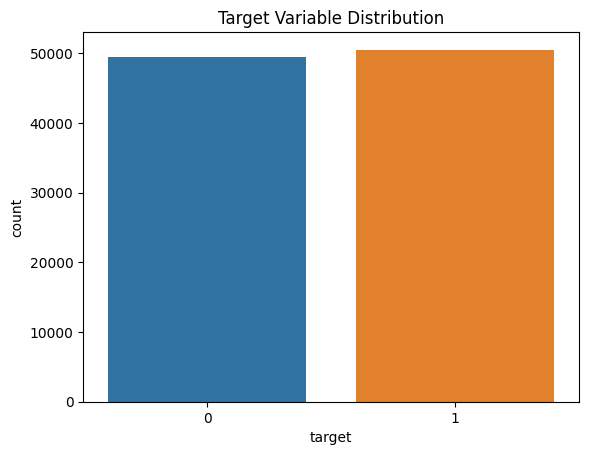

In [74]:
# Target Variable Distribution
sns.countplot(x=y)
plt.title("Target Variable Distribution")
plt.show()


In [75]:
X['DateAS']

0        2018-09-10 10:11:00
1        2018-08-16 00:01:00
2        2018-09-20 23:20:00
3        2018-09-14 00:32:00
4        2018-09-15 19:34:00
                ...         
99995    2018-09-21 00:59:00
99996    2018-08-10 07:23:00
99997    2018-08-26 23:51:00
99998    2018-06-04 17:13:00
99999    2018-07-14 15:36:00
Name: DateAS, Length: 100000, dtype: object

In [76]:
# Preprocessing the DateAS field to extract the date alone:

df['DateAS'] = df['DateAS'].str.split(' ').str[0]
X['DateAS'] = df['DateAS']


In [77]:
df.DateAS.nunique() # number of unique values in the 'DateAS' column  

566

In [78]:
X.SignatureVersion.nunique() # number of unique values in the 'SignatureVersion' column  

2735

In [79]:
X['SignatureVersion'].head(2)

0    1.275.1003.0
1    1.273.1465.0
Name: SignatureVersion, dtype: object

In [80]:
# Extracts and prints the unique first parts of 'SignatureVersion' values before the dot.
l1=set([])
for i in X['SignatureVersion']:
  l1.add(i.split('.')[0])
print(l1)


{'1'}


In [81]:
# Keeps only the second part of 'SignatureVersion' after the first dot.
X['SignatureVersion']=X['SignatureVersion'].apply(lambda x: x.split('.')[1])

In [82]:
X.SignatureVersion.nunique()

28

In [83]:
X['SignatureVersion'].head(2)

0    275
1    273
Name: SignatureVersion, dtype: object

In [84]:
X.DateAS.head(5)

0    2018-09-10
1    2018-08-16
2    2018-09-20
3    2018-09-14
4    2018-09-15
Name: DateAS, dtype: object

In [85]:
l1=set([])
for i in X.DateAS:
  l1.add(str(i).split('-')[0])
print(l1)
# Extracts and stores the year part from the 'DateAS' column in a set.

{'2017', '2016', '2018'}


In [86]:
X['OSVersion']

0        10.0.0.0
1        10.0.0.0
2        10.0.0.0
3        10.0.0.0
4        10.0.0.0
           ...   
99995    10.0.0.0
99996    10.0.0.0
99997    10.0.0.0
99998    10.0.0.0
99999    10.0.0.0
Name: OSVersion, Length: 100000, dtype: object

In [87]:
# Processing the OSVersion field
X['OSVersion']=X['OSVersion'].apply(lambda x: x.split('.')[0])
# Extracts the first part (major version) from the 'OSVersion' column.

In [88]:
 X.NumericOSVersion

0        10.0.14393.2214
1         10.0.17134.228
2         10.0.17134.285
3         10.0.15063.850
4         10.0.17134.285
              ...       
99995     10.0.17134.319
99996     10.0.17134.165
99997     10.0.16299.309
99998      10.0.17134.48
99999     10.0.17134.228
Name: NumericOSVersion, Length: 100000, dtype: object

In [89]:
l2=set([])

for i in X.NumericOSVersion:
  l2.add(i.split('.')[2])
print(len(l2))

# Extracts the third part of the 'NumericOSVersion' and counts the number of unique values.

23


In [90]:
set1=set([])
for i in X.EngineVersion:
  set1.add(i.split('.')[2])
len(set1)

# Extracts the third part of 'EngineVersion' and calculates the number of unique values.

30

In [91]:
X.ProcessorCoreCount.unique()

array([ 4.,  2.,  6.,  8., 20.,  3., 12., nan,  1., 16., 28., 64., 10.,
       32., 24., 40.,  5., 48., 36., 56.])

In [92]:
# features to drop
cols_to_drop=['MachineID', 'IsBetaUser',
              'CityID', 'AutoSampleSubmissionEnabled',
               'OEMModelID','IsFlightsDisabled', 'FirmwareVersionID', 'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OsPlatformSubRelease',
               'OSBuildNumber', 'OSBranch', 'OSArchitecture', 'OSSkuFriendlyName'
              ]
len(cols_to_drop)

14

In [93]:
l1=set([])
for i in X.NumericOSVersion:
  l1.add(i.split('.')[0])
print(l1)

# Extracts and stores the first part of NumericOSVersion

{'10'}


In [94]:
X_new=X.drop(cols_to_drop,axis=1)
# Drops the specified columns from X and stores the result in X_new.

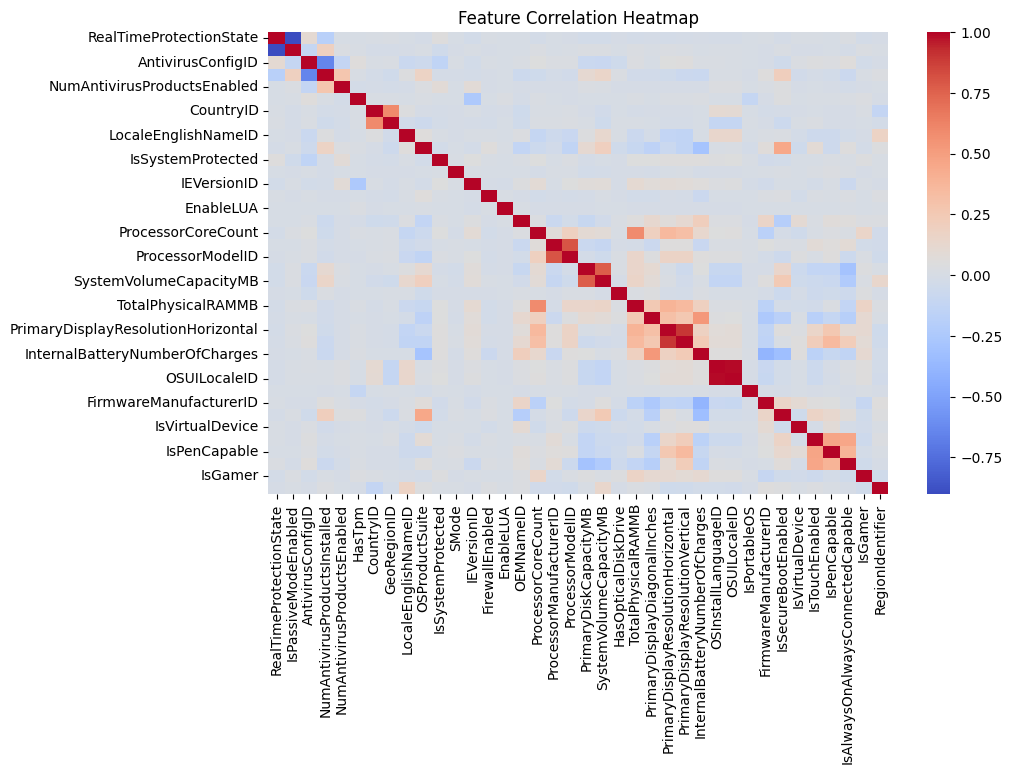

In [95]:
#  Feature Correlation Heatmap
X_numeric_corr = X_new.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(X_numeric_corr.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [96]:
X_numeric_corr.corr()

,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,GeoRegionID,LocaleEnglishNameID,OSProductSuite,...,OSUILocaleID,IsPortableOS,FirmwareManufacturerID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier
RealTimeProtectionState,1.000000,-0.901426,0.107907,-0.184396,-0.001299,-0.001035,0.010743,0.013603,0.002851,-0.010316,...,-0.012716,-0.002645,0.010112,-0.015123,0.007044,0.009187,0.003635,0.019879,-0.023005,-0.009479
IsPassiveModeEnabled,-0.901426,1.000000,-0.111384,0.195344,0.023414,0.004929,-0.010327,-0.013213,-0.006799,0.011408,...,0.011356,0.000279,-0.009343,0.017269,-0.007088,-0.005307,-0.000579,-0.016466,0.025863,0.007966
AntivirusConfigID,0.107907,-0.111384,1.000000,-0.647222,-0.115021,0.059230,0.008457,0.017477,-0.077096,-0.055607,...,0.011826,0.004179,-0.009623,-0.044251,0.023157,0.034506,0.033627,0.060264,-0.026385,-0.008294
NumAntivirusProductsInstalled,-0.184396,0.195344,-0.647222,1.000000,0.273791,0.010237,-0.017957,-0.042795,0.041475,0.173563,...,0.008324,-0.009253,0.054231,0.210308,-0.035076,-0.011100,-0.029814,-0.075055,0.008620,0.028845
NumAntivirusProductsEnabled,-0.001299,0.023414,-0.115021,0.273791,1.000000,-0.020977,-0.014795,-0.022393,-0.015629,0.027037,...,0.029986,-0.002684,0.015469,0.037019,-0.009299,0.000088,-0.005245,-0.018295,-0.009562,0.000937
HasTpm,-0.001035,0.004929,0.059230,0.010237,-0.020977,1.000000,0.007648,0.005161,0.000168,0.013049,...,-0.002463,-0.107099,-0.004301,0.035167,0.000676,0.011799,0.009900,0.013294,0.028136,-0.003924
CountryID,0.010743,-0.010327,0.008457,-0.017957,-0.014795,0.007648,1.000000,0.597061,0.040761,-0.003745,...,0.098900,-0.000919,-0.018788,-0.013022,-0.005375,0.004135,-0.008432,-0.008681,0.017307,-0.117528
GeoRegionID,0.013603,-0.013213,0.017477,-0.042795,-0.022393,0.005161,0.597061,1.000000,-0.036492,-0.057874,...,-0.113351,0.004797,-0.003138,-0.067412,0.010703,0.023614,-0.002761,-0.009481,-0.002651,-0.022153
LocaleEnglishNameID,0.002851,-0.006799,-0.077096,0.041475,-0.015629,0.000168,0.040761,-0.036492,1.000000,0.061654,...,0.132710,-0.002586,0.014088,0.023168,-0.019462,-0.056046,-0.061525,-0.032057,-0.003195,0.169065
OSProductSuite,-0.010316,0.011408,-0.055607,0.173563,0.027037,0.013049,-0.003745,-0.057874,0.061654,1.000000,...,0.012323,-0.017935,0.071007,0.454726,-0.051540,0.086735,-0.060887,0.050258,-0.022239,0.039537


In [97]:
new_columns=X_new.columns
# Store the column names of X_new in new_columns

### Imputating all the null values with frequent ones:


In [98]:
# Replace occurrences of 'Unknown', 'UNKNOWN', and 'Unspecified' with NaN in categorical columns
for i in X_new:
  if ("UNKNOWN" in X_new[i].unique()) or ('Unknown' in X_new[i].unique()) or ("Unspecified" in X_new[i].unique()):
    X_new[i].replace('Unknown',np.nan,inplace=True)
    X_new[i].replace('UNKNOWN',np.nan,inplace=True)
    X_new[i].replace('Unspecified',np.nan,inplace=True)

In [99]:
# Identify columns with missing values and impute them using the most frequent value
temp=X_new.isna().sum()
cols_to_impute=temp[temp>0].index
si=SimpleImputer(strategy='most_frequent')
X_new[cols_to_impute]=si.fit_transform(X_new[cols_to_impute])

### Feature Engineering

In [100]:
# Creating a new feature: Number_of_Pixels (product of display resolution)
X_new['Number_of_Pixels']=X_new['PrimaryDisplayResolutionHorizontal']*X_new['PrimaryDisplayResolutionVertical']
X_new.drop(['PrimaryDisplayResolutionHorizontal','PrimaryDisplayResolutionVertical'],axis=1,inplace=True)

In [101]:
# Fixing incorrect values in EnableLUA
X_new['EnableLUA'].value_counts()
X_new['EnableLUA'].replace(48,1,inplace=True)

In [102]:
# Combining MDC2FormFactor and ChassisType
X_new['MDC2_ChassisType']=X_new['MDC2FormFactor']+'_'+X_new['ChassisType']

In [103]:
X_new.MDC2_ChassisType.nunique()

100

In [104]:
X_new.drop(['MDC2FormFactor','ChassisType'],axis=1,inplace=True)

In [105]:
# Combining HasOpticalDiskDrive and PrimaryDiskType
X_new['HasOptical_PrimaryDiskType']=X_new['HasOpticalDiskDrive'].astype(str)+'_'+X_new['PrimaryDiskType']

In [106]:
X_new.HasOptical_PrimaryDiskType.value_counts()

HasOptical_PrimaryDiskType
0_HDD    65701
0_SSD    26159
1_HDD     6404
1_SSD     1736
Name: count, dtype: int64

In [107]:
X_new.drop(['HasOpticalDiskDrive','PrimaryDiskType'],axis=1,inplace=True)

In [108]:
# Select numerical features for scaling and further processing
X_numeric=X_new[['SystemVolumeCapacityMB', 'PrimaryDiskCapacityMB', 'ProcessorCoreCount',
                 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'Number_of_Pixels',
                 'InternalBatteryNumberOfCharges', 'NumAntivirusProductsInstalled']]

### Scaling Numeric Features

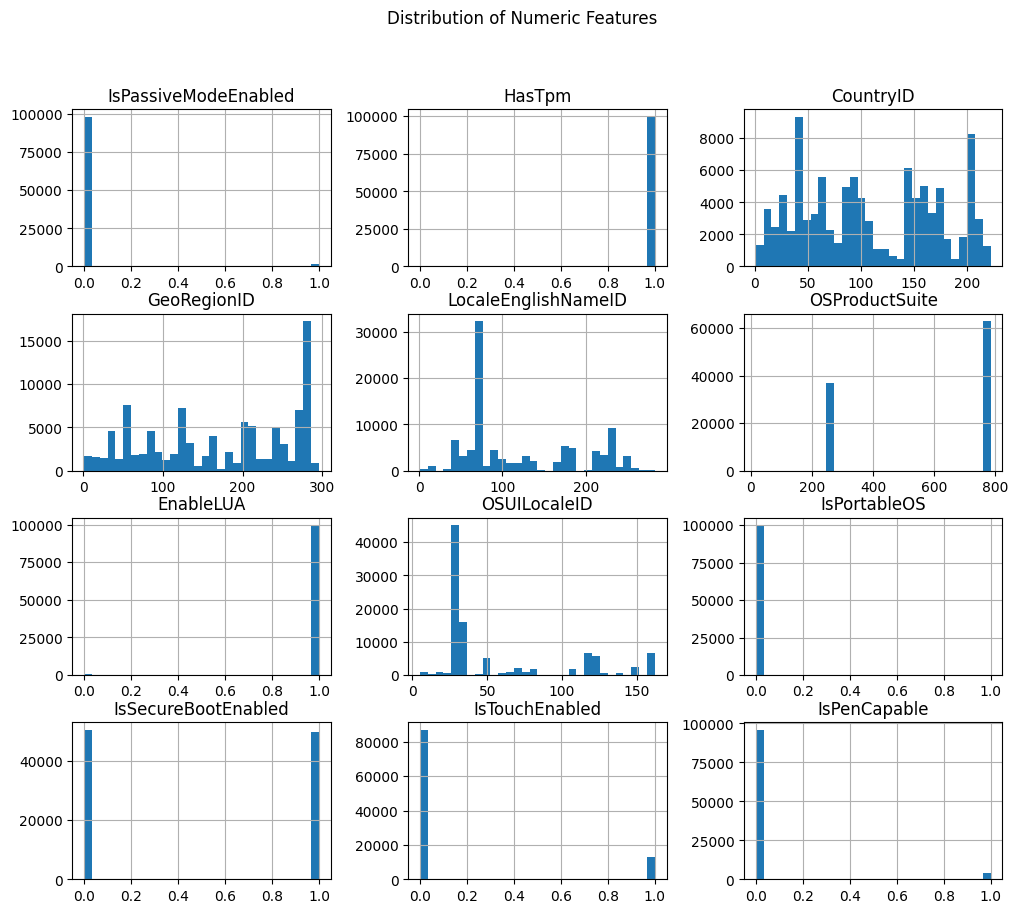

In [109]:
# Distribution of Numeric Features
X_new.hist(figsize=(12, 10), bins=30)
plt.suptitle("Distribution of Numeric Features")
plt.show()


In [110]:
# scaling the numeric fields

from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
X_numeric_scaled=ss.fit_transform(X_numeric)
X_numeric_scaled=pd.DataFrame(X_numeric_scaled,columns=X_numeric.columns)

X_numeric_scaled['NumAntivirusProductsInstalled']=X_new['NumAntivirusProductsInstalled']


In [111]:
X_numeric_scaled.head(2)

,SystemVolumeCapacityMB,PrimaryDiskCapacityMB,ProcessorCoreCount,TotalPhysicalRAMMB,PrimaryDisplayDiagonalInches,Number_of_Pixels,InternalBatteryNumberOfCharges,NumAntivirusProductsInstalled
0,-1.131211,-1.421212,-0.005654,-1.061141,-1.444204,-0.520304,-0.591178,1.0
1,1.758759,1.243157,-0.005654,-0.422587,0.446505,-0.028104,1.691538,1.0


In [112]:
X_categorical=X_new.drop(X_numeric.columns,axis=1)

In [113]:
X.OSVersion.value_counts()

OSVersion
10    98373
6      1627
Name: count, dtype: int64

In [114]:
# Convert all columns in X_numeric_scaled to numeric data types
for i in X_numeric_scaled.columns:
  X_numeric_scaled[i]=pd.to_numeric(X_numeric_scaled[i])

### One-Hot Encoding Categorical Features

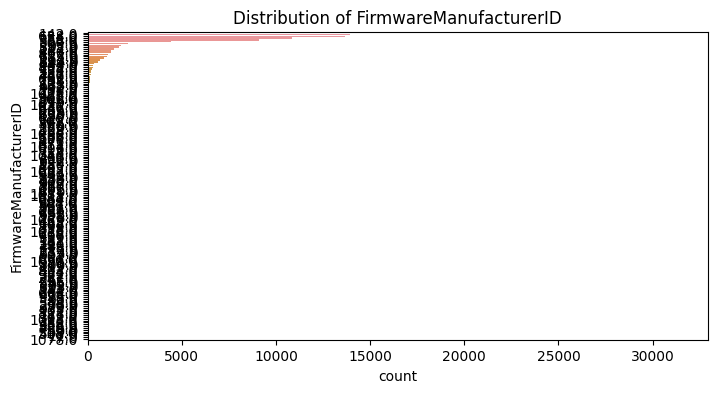

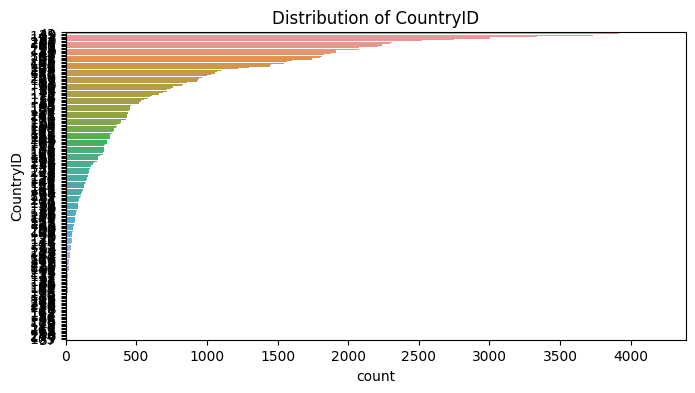

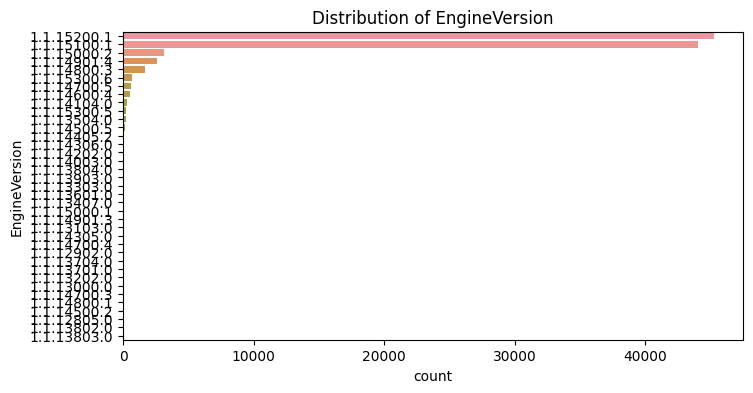

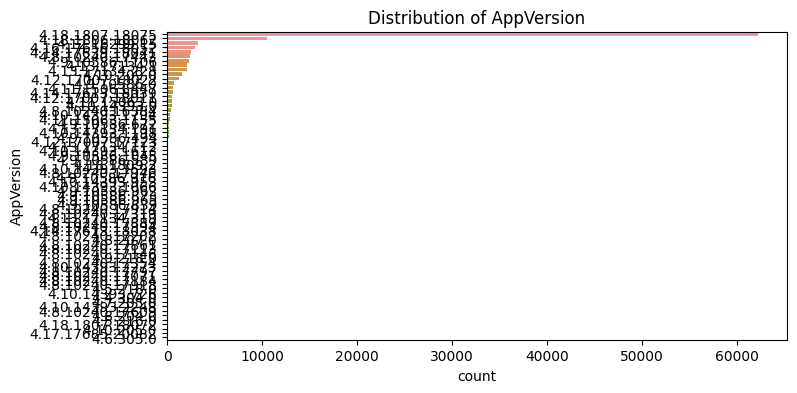

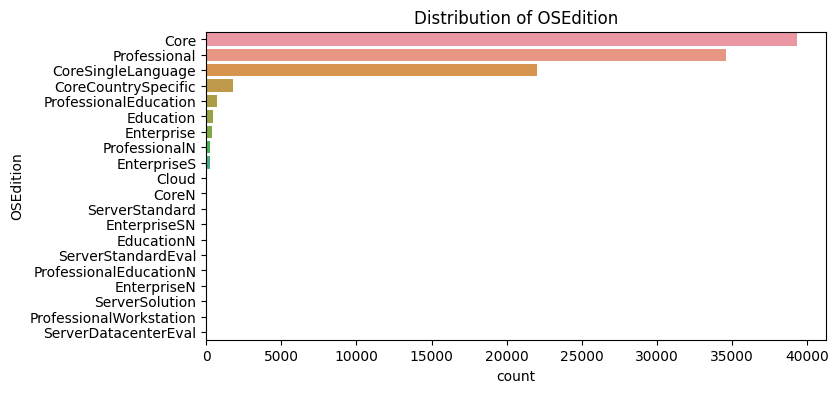

In [115]:
import random 
random_columns = random.sample(list(X_categorical.columns), 5)
for col in random_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=X_new[col], order=X_new[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()

In [116]:
# encoding the categorical variables and applying onehot encoding
onehot=OneHotEncoder(handle_unknown='ignore')
X_categorical_encoded=onehot.fit_transform(X_categorical)

In [117]:
X_categorical_encoded.shape, X_numeric_scaled.shape

((100000, 7049), (100000, 8))

In [118]:
# Converting X_cols_without_preprocessing to sparse matrix
from scipy.sparse import csr_matrix
X_numeric_scaled=csr_matrix(X_numeric_scaled)

### Concatenating Processed Features

In [119]:
X_concat=sp.hstack((X_numeric_scaled,X_categorical_encoded))
X_concat.shape

(100000, 7057)

## Pipleline

In [120]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack

class DateExtractor(BaseEstimator, TransformerMixin):
    """Extracts the date from DateAS field."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['DateAS'] = X['DateAS'].apply(lambda x: str(x).split(' ')[0])
        return X

class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Applies feature engineering steps like extracting numeric parts and combining fields."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Process SignatureVersion (keeping only second part)
        X['SignatureVersion'] = X['SignatureVersion'].apply(
            lambda x: x.split('.')[1] if isinstance(x, str) and '.' in x else x
        )

        # Process OSVersion (keeping only first part)
        X['OSVersion'] = X['OSVersion'].apply(lambda x: x.split('.')[0] if isinstance(x, str) else x)
        
        # Combine PrimaryDisplayResolutionHorizontal and PrimaryDisplayResolutionVertical
        X['Number_of_Pixels'] = X['PrimaryDisplayResolutionHorizontal'] * X['PrimaryDisplayResolutionVertical']
        X.drop(['PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical'], axis=1, inplace=True)
        
        # Replace value 48 in EnableLUA with 1
        X['EnableLUA'] = X['EnableLUA'].replace(48, 1)
        
        # Combine MDC2FormFactor and ChassisType
        X['MDC2_ChassisType'] = X['MDC2FormFactor'].astype(str) + "_" + X['ChassisType'].astype(str)
        X.drop(['MDC2FormFactor', 'ChassisType'], axis=1, inplace=True)

        # Combine HasOpticalDiskDrive and PrimaryDiskType
        X['HasOptical_PrimaryDiskType'] = X['HasOpticalDiskDrive'].astype(str) + "_" + X['PrimaryDiskType'].astype(str)
        X.drop(['HasOpticalDiskDrive', 'PrimaryDiskType'], axis=1, inplace=True)

        return X

class ColumnDropper(BaseEstimator, TransformerMixin):
    """Drops redundant or unnecessary columns."""
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.cols_to_drop, axis=1, errors='ignore')

# Define columns
cols_to_drop = [
    'MachineID', 'IsBetaUser', 'CityID', 'AutoSampleSubmissionEnabled',
    'OEMModelID', 'IsFlightsDisabled', 'FirmwareVersionID', 'OSBuildNumberOnly',
    'OSBuildRevisionOnly', 'OsPlatformSubRelease', 'OSBuildNumber', 'OSBranch',
    'OSArchitecture', 'OSSkuFriendlyName'
]

numeric_features = [
    'SystemVolumeCapacityMB', 'PrimaryDiskCapacityMB', 'ProcessorCoreCount',
    'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 'Number_of_Pixels',
    'InternalBatteryNumberOfCharges', 'NumAntivirusProductsInstalled'
]

categorical_features = ['OSVersion', 'SignatureVersion', 'MDC2_ChassisType', 'HasOptical_PrimaryDiskType']

# Pipelines for different transformations
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Final pipeline
final_pipeline = Pipeline([
    ('date_extractor', DateExtractor()),
    ('feature_engineer', FeatureEngineer()),
    ('column_dropper', ColumnDropper(cols_to_drop)),
    ('preprocessing', preprocessor)
])

# Models

In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [122]:
# from sklearn.dummy import DummyClassifier 
# model = DummyClassifier().fit(X,y) 

# X_test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv") 
# y_pred=model.predict(X_test)
 
# submission = pd.DataFrame({"id": range(0,X_test.shape[0]), "target": y_pred})
# submission.to_csv('submission.csv',index=False)

In [123]:
import warnings
warnings.filterwarnings(action='ignore')

## XGBOOST

In [124]:
# from xgboost import XGBClassifier


# # applying pipepline
# X_transformed = final_pipeline.fit_transform(X)
# X_train, X_test, y_train, y_test=train_test_split(X_transformed, y, test_size=0.2, random_state=42)
# xgb=XGBClassifier(n_estimators=200,n_jobs=-1, max_depth=10)
# xgb.fit(X_train,y_train)
# print(xgb)
# print(xgb.get_params())

In [125]:
# y_train_pred=xgb.predict(X_train)
# y_pred=xgb.predict(X_test)
# print(classification_report(y_test, y_pred))

In [126]:
# accuracy_score(y_test,y_pred)

In [127]:
# test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv") 

# test_transformed = final_pipeline.transform(test_df)  # Apply the same transformations to test data

# y_pred = xgb.predict(test_transformed)

# submission = pd.DataFrame({"id": range(0, test_transformed.shape[0]), "target": y_pred})
# submission.to_csv("submission.csv", index=False)

# print("Submission file saved as submission.csv")


## Logistic Regression

In [128]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

# # applying pipepline
# X_transformed = final_pipeline.fit_transform(X)
# X_train, X_test, y_train, y_test=train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# lg=LogisticRegression(max_iter=300)
# lg.fit(X_train,y_train)

# y_train_pred=lg.predict(X_train)
# y_pred=xgb.predict(X_test)
# print(classification_report(y_test, y_pred))

# accuracy_score(y_test,y_pred)

In [129]:
# test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv") 

# test_transformed = final_pipeline.transform(test_df)  # Apply the same transformations to test data

# y_pred = lg.predict(test_transformed)

# submission = pd.DataFrame({"id": range(0, test_transformed.shape[0]), "target": y_pred})
# submission.to_csv("submission.csv", index=False)

# print("Submission file saved as submission.csv")


## MULTI LAYER PERCEPTRON

In [130]:
# from sklearn.model_selection import train_test_split
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # applying pipepline
# X_transformed = final_pipeline.fit_transform(X)
# X_train, X_test, y_train, y_test=train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# # Create an MLP classifier
# mlp = MLPClassifier(hidden_layer_sizes=(50, 20, 20, 10, 5), activation='relu', solver='adam',
#                     max_iter=200, random_state=42)

# # Train the model
# mlp.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = mlp.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")
# print(classification_report(y_test, y_pred))

In [131]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameter grid for Logistic Regression
# param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 5, 7, 9, 10, 100]}

# # Split the data into training and test sets (assuming X and y are defined)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Apply GridSearchCV on the pipeline
# grid_search = GridSearchCV(preprocessing_pipeline, param_grid, cv=7, scoring='f1_macro')

# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)

# # Get the best model from grid search
# best_pipeline = grid_search.best_estimator_

# # Make predictions on the test data
# y_pred = best_pipeline.predict(X_test)

# # Calculate F1 Score (Macro Average)
# f1 = f1_score(y_test, y_pred, average='macro')

# # Print the results
# print("Best Logistic Regression Hyperparameters:", grid_search.best_params_)
# print(f"Logistic Regression F1 Score (Macro): {f1:.2%}")

## DecisionTreeClassifier

In [132]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import FunctionTransformer

# # Define preprocessing functions (replace_unknown_with_mode, label_encode_columns)
# # ... (Assuming these functions are already defined as in your previous code)

# # Define the full pipeline
# preprocessing_pipeline = Pipeline(steps=[
#     ('replace_unknown', FunctionTransformer(replace_unknown_with_mode, kw_args={'columns': columns_with_unknown})),
#     ('label_encoding', FunctionTransformer(label_encode_columns, kw_args={'categorical_columns': categorical_columns})),
#     ('classifier', DecisionTreeClassifier())  # Add DecisionTreeClassifier to the pipeline
# ])

# # Define hyperparameter grid for DecisionTreeClassifier
# param_grid = {
#     'classifier__criterion': ['gini', 'entropy'],
#     'classifier__splitter': ['best', 'random'],
#     'classifier__max_depth': [None, 10, 20, 30],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4]
# }

# # Split data (assuming X and y are defined)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Apply GridSearchCV on the pipeline
# dec_tree_grid_search = GridSearchCV(preprocessing_pipeline, param_grid, cv=5, scoring='accuracy')

# # Fit the grid search to the training data
# dec_tree_grid_search.fit(X_train, y_train)

# # Get the best model from grid search
# best_pipeline = dec_tree_grid_search.best_estimator_

# # Make predictions on the test data
# y_pred = best_pipeline.predict(X_test)

# # Calculate accuracy
# acc = accuracy_score(y_test, y_pred)
# print(f"CART Model Accuracy: {acc:.2%}")
# print("Best Hyperparameters:", dec_tree_grid_search.best_params_)

## LightGBM

In [133]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Applying the pipeline
X_transformed = final_pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Create a LightGBM classifier
lgbm = LGBMClassifier(
    n_estimators=200,   # Number of trees
    learning_rate=0.05,  # Step size for updating weights
    max_depth=-1,       # Maximum depth of trees
    num_leaves=63,      # Number of leaves per tree (controls complexity)
    boosting_type='gbdt',  # Gradient Boosting Decision Tree
    random_state=42
)

# Train the model
lgbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


# CatGBM algorith

[LightGBM] [Info] Number of positive: 40403, number of negative: 39597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505038 -> initscore=0.020151
[LightGBM] [Info] Start training from score 0.020151
Accuracy: 0.60195
              precision    recall  f1-score   support

           0       0.61      0.54      0.57      9878
           1       0.60      0.66      0.63     10122

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000



In [134]:
test_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv") 

test_transformed = final_pipeline.transform(test_df)  # Apply the same transformations to test data

y_pred = lgbm.predict(test_transformed)

submission = pd.DataFrame({"id": range(0, test_transformed.shape[0]), "target": y_pred})
submission.to_csv("submission.csv", index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
